In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import torch
import torch.nn as nn

from utils.tokenMaker import Lang
from utils.tool import padding, flatMutileLength, fixString
from model.BigModel import ImgToSeq
from convertSrtEN import cleanString
useCuda = True
device = torch.device("cuda" if useCuda else "cpu")

In [2]:
datas = pd.read_csv("others/train.csv")
datas[:5]

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
import pickle
import os
ModalDir = "ImgSub2Sub/models/bken_fix_150"
with open(os.path.join(ModalDir, "Lang.pkl"), 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModalDir, len(lang)))
modal = torch.load(os.path.join(ModalDir, "SubImgModel.30.pth")).eval().to(device)

Load lang model: ImgSub2Sub/models/bken_fix_150. Word size: 15479


In [8]:
minidata = datas[:1000]
minidata = minidata.assign(cos = lambda x: 0.5)
minidata = minidata.assign(eucl = lambda x: 0.5)

In [19]:
def getEncoder(modal, sub):
    subVar =  torch.LongTensor(lang.sentenceToVector(sub, sos=False, eos=False)).to(device).unsqueeze(0)
    return modal.subRnn(subVar)[0][:,-1,:]
def getWordEncoder(modal, sub):
    subVar =  torch.LongTensor(lang.sentenceToVector(sub, sos=False, eos=False)).to(device).unsqueeze(0)
    return modal.subRnn.embedding(subVar).mean(dim=1)
def getCos(row):
    eq1 = getEncoder(modal, cleanString(row["question1"]))
    eq2 = getEncoder(modal, cleanString(row["question2"]))
    data = cos(eq1, eq2).mean() #cos
    return data.cpu().detach().item()
def getEuclidean(row):
    eq1 = getEncoder(modal, cleanString(row["question1"]))
    eq2 = getEncoder(modal, cleanString(row["question2"]))
    data = ((eq1-eq2)**2).sum()**0.5 #o
    return data.cpu().detach().item()

cos = nn.CosineSimilarity(dim=1)

In [21]:
for index, row in minidata.iterrows():
    minidata.loc[index, "cos"] = getCos(row)
    minidata.loc[index, "eucl"] = getEuclidean(row)

In [22]:
from sklearn.metrics import classification_report
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(minidata[["cos"]], minidata["is_duplicate"])
minidata["cmp"] = clf.predict(minidata[["cos"]])
print(classification_report(y_true=minidata["is_duplicate"], y_pred=minidata["cmp"]))
#cos

             precision    recall  f1-score   support

          0       0.73      0.73      0.73       620
          1       0.56      0.56      0.56       380

avg / total       0.66      0.66      0.66      1000



In [23]:
from sklearn.metrics import classification_report
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(minidata[["eucl"]], minidata["is_duplicate"])
minidata["cmp"] = clf.predict(minidata[["eucl"]])
print(classification_report(y_true=minidata["is_duplicate"], y_pred=minidata["cmp"]))
#幾何

             precision    recall  f1-score   support

          0       0.71      0.79      0.75       620
          1       0.58      0.48      0.52       380

avg / total       0.66      0.67      0.66      1000



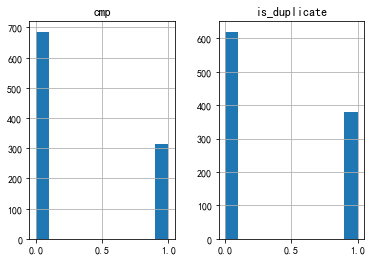

In [24]:
minidata[["cmp", "is_duplicate"]].hist()
plt.show()

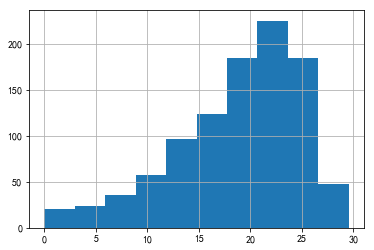

count    1000.000000
mean       18.841783
std         6.149757
min         0.000000
25%        15.263359
50%        20.010601
75%        23.410573
max        29.571533
Name: eucl, dtype: float64

In [25]:
minidata["eucl"].hist(bins=10)
plt.show()
minidata["eucl"].describe()

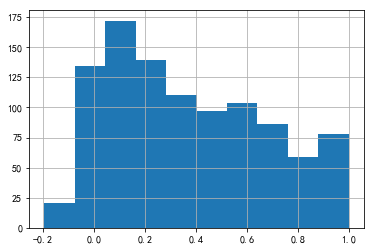

count    1000.000000
mean        0.369838
std         0.306327
min        -0.195279
25%         0.107970
50%         0.321715
75%         0.607917
max         1.000000
Name: cos, dtype: float64

In [26]:
minidata["cos"].hist(bins=10)
plt.show()
minidata["cos"].describe()

In [1]:
import jieba

In [2]:
sc = "這是一首間單的小情歌"
sce = "你好Andy 幫我放東西"

In [5]:
list(jieba.cut(sce))

['你好', 'Andy', ' ', '幫', '我', '放東西']

In [ ]:
class LangV2:
    def __init__(self, name, split="jieba"):
        self.name = name
        self.split = split
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.n_words = 0
        
        self.addWord("PAD")
        self.addWord("SOS")
        self.addWord("EOS")
        self.addWord("UNK")
        
    def  __getitem__(self, key):
        if isinstance(key, str):
            if key in self.word2index:
                return self.word2index[key]
            else:
                return self.word2index["UNK"]
        elif isinstance(key, int):
            if key < self.n_words:
                return self.index2word[key]
        return None
    def __len__(self):
        return self.n_words
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    def __splitSentence(self, s):
        if self.split == "":
            return s
        if self.split == "jieba":
            jieba.cut(s)
        else:
            return s.split(self.split)
    def addSentance(self, sent):
        for w in self.__splitSentence(sent):
            self.addWord(w)
    def sentenceToVector(self, s, sos = False, eos = False):
        numS = []
        if sos: 
            numS.append(self.word2index["SOS"])
        for w in self.__splitSentence(s):
            if w in self.word2index:
                numS.append(self.word2index[w])
            else:
                numS.append(self.word2index["UNK"])
        if eos:
            numS.append(self.word2index["EOS"])
        return numS
    def vectorToSentence(self, v):
        if self.word2index["SOS"] in v:
            v.remove(self.word2index["SOS"])
        if self.word2index["EOS"] in v:
            v.remove(self.word2index["EOS"])

        s = self.split.join(self.index2word[i] for i in v)
        return s